# MLOps Zoomcamp (Week 1)

<br> Aim is to predict trip times
<br> We will be using data for 'for hire vehicles' for jan and feb 2021

### Import the required libraries

In [26]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Read Data

In [ ]:
url_jan = 'https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet'
url_feb = 'https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2022-02.parquet'

response_jan = requests.get(url_jan)
open(jan_data,"wb").write(response_jan.content)

response_feb = requests.get(url_feb)
open(feb_data,"wb").write(response_feb.content)

In [84]:
df_jan_21 = pd.read_parquet(jan_data)
df_feb_21 = pd.read_parquet(feb_data)

In [85]:
df_jan_21.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [86]:
df_jan_21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 61.6+ MB


In [87]:
print(df_jan_21.shape[0],df_feb_21.shape[0])

1154112 1037692


### Calculating trip times

In [88]:
def calculate_duration(df):
    df['duration'] = df['dropOff_datetime'] - df['pickup_datetime']
    df.duration = df.duration.apply(lambda x: x.total_seconds()/60)
    return df

In [89]:
df_jan_21 = calculate_duration(df_jan_21)
df_feb_21 = calculate_duration(df_feb_21)

In [90]:
df_jan_21.duration.mean()

19.1672240937939

In [91]:
df_feb_21.duration.mean()

20.70698622520125

### Distribution of duration

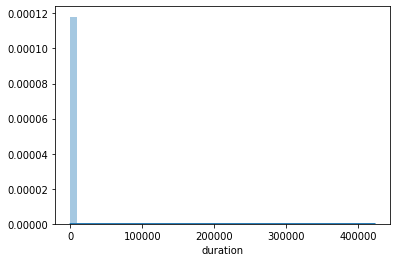

In [92]:
sns.distplot(df_jan_21.duration)

In [93]:
df_jan_21.duration.describe(percentiles=[0.95,0.98,0.99])

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
50%      1.340000e+01
95%      4.725000e+01
98%      6.613333e+01
99%      9.030000e+01
max      4.233710e+05
Name: duration, dtype: float64

In [94]:
# Filter out rows which have duration less than 1min or more than 60mins
df_jan_21 = df_jan_21[(df_jan_21.duration >=1) & (df_jan_21.duration <= 60)]
df_feb_21 = df_feb_21[(df_feb_21.duration >=1) & (df_feb_21.duration <= 60)]

In [95]:
print(df_jan_21.shape[0],df_feb_21.shape[0])

1109826 990113


In [96]:
df_jan_21.shape

(1109826, 8)

In [97]:
df_feb_21.shape

(990113, 8)

### Missing values

In [98]:
categorical = ['PUlocationID','DOlocationID']

In [99]:
print(df_jan_21.PUlocationID.isna().sum() ,df_jan_21.DOlocationID.isna().sum() )

927008 147907


In [100]:
print(df_feb_21.PUlocationID.isna().sum() ,df_feb_21.DOlocationID.isna().sum() )

848661 134760


In [101]:
df_jan_21.PUlocationID = df_jan_21.PUlocationID.fillna(value="-1")
df_feb_21.PUlocationID = df_feb_21.PUlocationID.fillna(value="-1")

In [102]:
df_jan_21.DOlocationID = df_jan_21.DOlocationID.fillna(value="-1")
df_feb_21.DOlocationID = df_feb_21.DOlocationID.fillna(value="-1")

In [103]:
df_jan_21[categorical] = df_jan_21[categorical].astype(str)
df_feb_21[categorical] = df_feb_21[categorical].astype(str)

In [104]:
df_jan_21[(df_jan_21.PUlocationID)=="-1"]

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,-1,-1,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,-1,-1,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,-1,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,-1,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,-1,71.0,None,B00037,9.050000
...,...,...,...,...,...,...,...,...
1154094,B03202,2021-01-31 23:57:02,2021-02-01 00:14:27,-1,177.0,None,B03202,17.416667
1154096,B03239,2021-01-31 23:07:00,2021-01-31 23:17:28,-1,70.0,None,B03239,10.466667
1154097,B03239,2021-01-31 23:27:39,2021-01-31 23:33:38,-1,82.0,None,B03239,5.983333
1154098,B03239,2021-01-31 23:40:10,2021-01-31 23:52:07,-1,56.0,None,B03239,11.950000


In [83]:
927008/1109826

0.8352732770722617

### Feature Engineering

In [106]:
dv = DictVectorizer()

In [107]:
train_dicts = df_jan_21[categorical].to_dict(orient='records')

In [108]:
X_train = dv.fit_transform(train_dicts)

In [109]:
X_train

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

In [111]:
y_train = df_jan_21['duration'].values

In [113]:
y_train

array([17.        , 17.        ,  8.28333333, ..., 16.2       ,
       19.43333333, 36.        ])

In [115]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [116]:
y_pred = lr.predict(X_train)

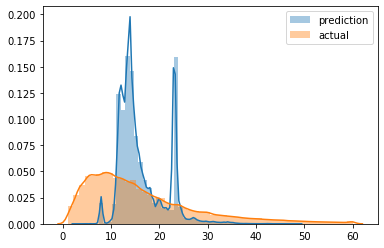

In [118]:
sns.distplot(y_pred,label='prediction')
sns.distplot(y_train,label='actual')
plt.legend()

### Evaluation

In [126]:
mean_squared_error(y_train,y_pred,squared=False)

10.528519107201793

### Test data

In [121]:
test_data = df_feb_21[categorical].to_dict(orient='records')

In [122]:
X_test = dv.transform(test_data)
y_test = df_feb_21['duration'].values

In [123]:
test_pred = lr.predict(X_test)

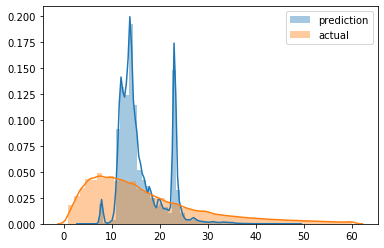

In [124]:
sns.distplot(test_pred,label='prediction')
sns.distplot(y_test,label='actual')
plt.legend()

In [127]:
mean_squared_error(y_test,test_pred,squared=False)

11.014283109432261